## Proof of concept for literature clustering with UMAP & HDBSCAN

Handling a lot literature data to find structure therein is an interesting challenge. A lot of work in this area is done using network analysis, but i figured that it might be interesting to use dimension reduction to produce nice visualizations of citation-landscape. Why? In the first place mostly because the visualizations IMHOP get much better. Especially when a temporal component is introduced or the data gets larger, visualizations of networks get realy ugly. 
But vizualisation is crucial to build intuitions about the structure of research fields, ergo, this alternative approach. 

To make plausible that the differentiation-power of this technique is high enough to be useful in structuring bibliographic data, I will use it to cluster WebOfScience-data of __journals from very different domains__, and see how good it *gets* them. 

First let's load some packages and the data (using the [metaknowledge](http://networkslab.org/metaknowledge/), which is great.)

[I think that I should not upload the sample data, as it belongs to Reuters, but if your institution has access, you can download you own, in *plaintext* format, and with all possible fields.]

In [387]:

import metaknowledge as mk
import pandas as pd

import numpy as np
from random import randint
import datetime
import scipy as scipy


%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi']= 130
# from matplotlib.pyplot import figure


# plt.style.use('fivethirtyeight')

# sns.set_context('poster')
# sns.set_style('white')
# #sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}

#For Tables:
from IPython.display import display
pd.set_option('display.max_columns', 500)

#For R (ggplot2)
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [388]:
date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")


RC = mk.RecordCollection("./V1/testingsample")


Now let us filter the data a little bit, kick out papers that miss important values, and look at a quick summary:

In [389]:
#print(RC.glimpse())
RC2 = mk.RecordCollection()

for R in RC:
    randnr = randint(0, 4)
    
    if len(R.getCitations().get("author"))>=1: # and randnr==0 apply condition in order to downsample records
        #Here we kick out every paper that cites less then 3 authors. Why? because they
        #are so dissimilar from the others, that they only produce noise.  
   
        try:
            R['year']
            #R['abstract']  #Add this when working with abstracts. It removes every paper that has none. 
            #This can sometimes remove whole journals, that are archived without abstracts, so handle with care.
            RC2.add(R)
        except KeyError:
            pass
    else:
        pass
    

print(RC2.glimpse(compact=True))


RC = RC2


+RecordCollection glimpse made at: 2018-08-18 02:07:24++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|2491 Records from Empty+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                            Shelah, S|1  JOURNAL OF INVESTIGATIVE DERMATOLOGY|1          Kant I, CRITIQUE PURE REASON|
|2                          KLIGMAN, AM|1        ARCHIVE FOR MATHEMATICAL LOGIC|2 MELZACK R, 1975, PAIN, V1, P277, DOI.|
|3                            DUBNER, R|2                                  PAIN|3  Hajek P., 1998, METAMATHEMATICS FUZZ|
|4                           MELZACK, R|3                    IDEALISTIC STUDIES|4 Klapisch-Zuber Christiane, 1985, WOM.|
|4                            Pr

### Extracting the Features

In order to use UMAP and the clustering algorithm, we have to extract some features to work with. 

I have chosen to use two kinds:
+ cited works *and*
+ cited authors

*Cited works* are the precise citation string that the WOS-Collection uses. These are very good to get the fine-grained structure of the literature, as they can be very specific. They allow us for example to differentiate between the epistemologic and the political works of Robert Nozick. Cited authors on the other hand are to a certaint extent redundant, as they are only a less precise form of cited works. 
But they are valuable for us, as they give us a general corner in which a paper belongs. This allows us to use much more of our data, as relying only on cited works forces us to kick out many papers that are only weakly linked to the rest. 

Both types of features are extracted with scikit-learn and concatenated. Than we filter out everything that is weakly linked, as it tends to "ball up" in the UMAP without containing useful information.

In [390]:
########### Cited Works - Features ############

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
drc = pd.DataFrame.from_dict(RC.forNLP(extraColumns=['journal','AU','FU']))

d = []
citedAU = []
citestring =[]
for R in RC:

    d.append(list(set(R.getCitations().get("citeString")))) #To cluster by cited author
    citedAU.append(list(set(R.getCitations().get("author"))))
    citestring.append(list(set(R.getCitations().get("citeString"))))

drc["citedAU"] = citedAU
drc["citestring"] = citestring
#print(d[0])
authorslist = ['§'.join(filter(None,x)) for x in list(d)] 
#print(authorslist[0])

# vec = TfidfVectorizer(token_pattern=r'(?<=[^|§])[\s\w,\.:;]+(?=[$|§])')
vec = CountVectorizer(token_pattern=r'(?<=[§])[\s\w,\.:;\/\[\]-]+(?=[§])',binary=True, min_df = 3)#, min_df = 1)


Xrc = vec.fit_transform(authorslist)

In [391]:
########### Authors - Features ############

d = []
for R in RC:
    authors = list(set(R.getCitations().get("author")))
#    print(authors)
    authors = filter(None, authors)
    f = []
    for a in authors:
        f.append(' '.join([w for w in a.split(' ')if len(w)>2]))
        
    authors = f#' '.join(f)
    d.append(authors)
authorslist = [';'.join(filter(None,x)) for x in list(d)] 
vec = CountVectorizer(token_pattern=r'(?<=[;])[\s\w]+(?=[;])',binary=True, min_df = 10)

XrcAu = vec.fit_transform(authorslist)

In [392]:
########### Abstract - Features: Not used! ############

# d = []
# for R in RC:
#     try:
#         d.append(R['abstract'])
#     except KeyError:
#         d.append("")

# authorslist=d   
# vec = CountVectorizer(stop_words="english",ngram_range=(1,2), binary=True, min_df = 10, max_df = 1000)    

# XrcA = vec.fit_transform(authorslist)


In [393]:
k = [XrcAu,Xrc]
XrcFull = scipy.sparse.hstack(k).tocsr()

In [394]:
#display(drc["id"])
# xdf.loc[(xdf!=0).any(1)]
# display(xdf)

from scipy.sparse import coo_matrix, vstack
from scipy.sparse import csr_matrix
import scipy as scipy
row_names = np.array(drc["id"])

newdf=[]
a = 0
# index by name:
for x in range(0,XrcFull.shape[0]): #Xrc.shape[0]):
    row_idx, = np.where(row_names == drc["id"][x])
    if np.diff(XrcFull[row_idx].tocsr().indptr) >= 4:
        if a == 0:
            k = [XrcFull[row_idx]]
        if a != 0:
            k.append(XrcFull[row_idx])
        a = a+1
        newdf.append(drc.loc[x])
        
drc = pd.DataFrame(newdf).reset_index()
M = scipy.sparse.vstack((k))

#display(drc)

### Now for the [UMAP](https://github.com/lmcinnes/umap)
We produce three embeddings for our purposes. A one- and a two-dimensional for visualization-purposes, and a third one with many dimensions that we will use for clustering. We will plot the 2D-embedding with ggplot, so that we have something to look at:

In [395]:
import umap

try:
    drc = drc.drop('x',axis=1)
    drc = drc.drop('y',axis=1)

except KeyError:
    pass


embedding = umap.UMAP(n_neighbors=5,#small => local, large => global: 5-50
                      min_dist=0, #small => local, large => global: 0.001-0.5
                      metric='cosine').fit_transform(M)
embedding = pd.DataFrame(embedding)
embedding.columns = ['x','y']


C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


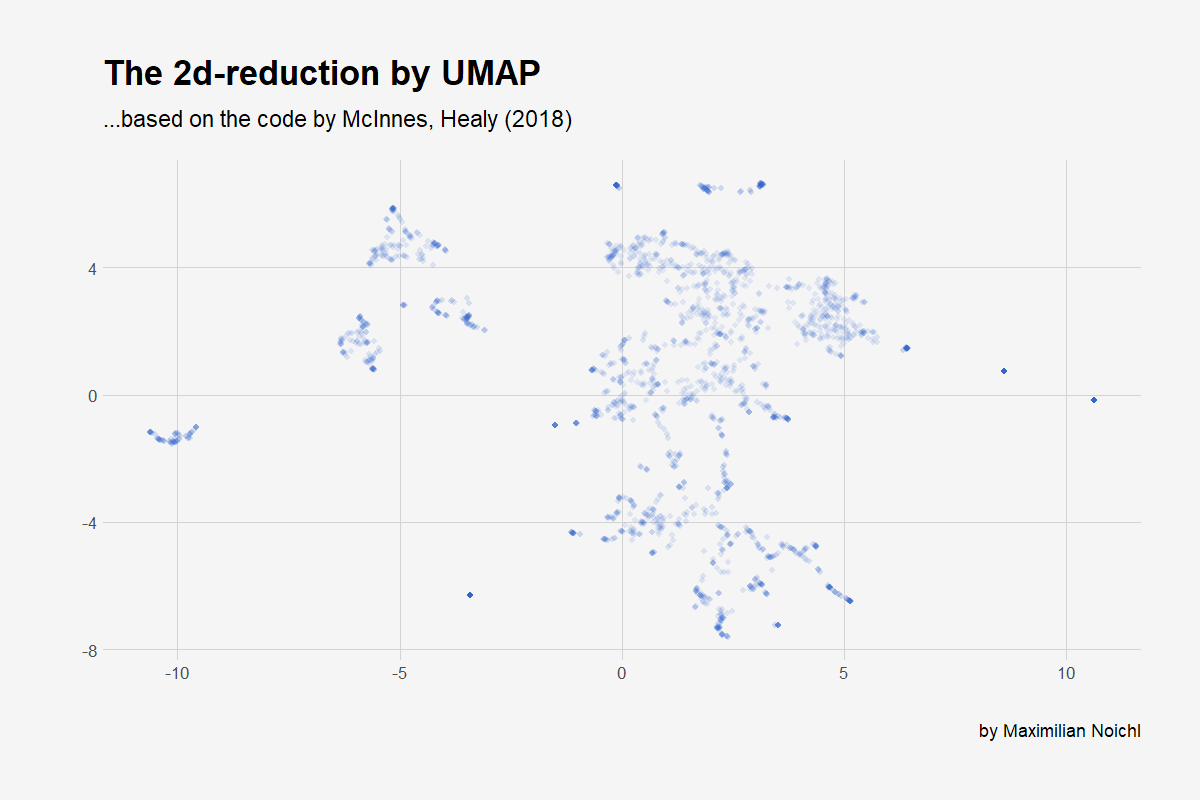

In [396]:
%%R -i embedding --width 1200 --height 800 -r 140 --bg #F5F5F5
library(hrbrthemes)
library(ggplot2)
library(fields)
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y,alpha = 1/density))+

 guides(alpha=FALSE)+

geom_point(color="#3366cc", pch=16,cex=1.2)+ theme_ipsum_rc()+
labs(x="", y="",
       title="The 2d-reduction by UMAP",
       subtitle="...based on the code by McInnes, Healy (2018)",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank()
)
p


In [397]:
try:
    drc = drc.drop('xI',axis=1)
except KeyError:
    pass

embeddingI = umap.UMAP(n_components=1,
                        n_neighbors=20,
                      min_dist=0,
                      metric='cosine').fit_transform(M)

embeddingIdf = pd.DataFrame(embeddingI)
embeddingIdf.columns = ['xI']
embeddingIdf2 = pd.concat([embeddingIdf['xI'], drc['year']],axis=1)
#plt.scatter(embeddingIdf2['xI'], drc['year'], color='grey')
embeddingI = embeddingIdf2

In [398]:
import umap

embeddingC = umap.UMAP(n_components = 30,
                      n_neighbors=30,#small => local, large => global: 5-50
                      min_dist=0, #small => local, large => global: 0.001-0.5
                      metric='cosine').fit_transform(M)
embeddingC = pd.DataFrame(embeddingC)

### Clustering with [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan)

Now we use HDBSCAN on the embedding with the most dimensions:


In [399]:
try:
    drc = drc.drop('cluster',axis=1)
except KeyError:
    pass

import hdbscan

#(min_cluster_size=500, min_samples=30, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=455, min_samples=35, gen_min_span_tree=True)

clusterer = hdbscan.HDBSCAN(min_cluster_size=90, min_samples=30, gen_min_span_tree=True)
clusterer.fit(embeddingC)
XCLUST = clusterer.labels_
clusternum = len(set( clusterer.labels_))-1


dfclust = pd.DataFrame(XCLUST)
dfclust.columns = ['cluster']



#plt.scatter(embedding['x'], embedding['y'], s=10, linewidth=0, c=cluster_colors, alpha=0.25)
#clusterer.condensed_tree_.plot()
#print(clusterer.condensed_tree_.to_pandas().head())
#clusterer.condensed_tree_.plot()
print(clusternum)


6


Now lets plot everything in ggplot:

C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


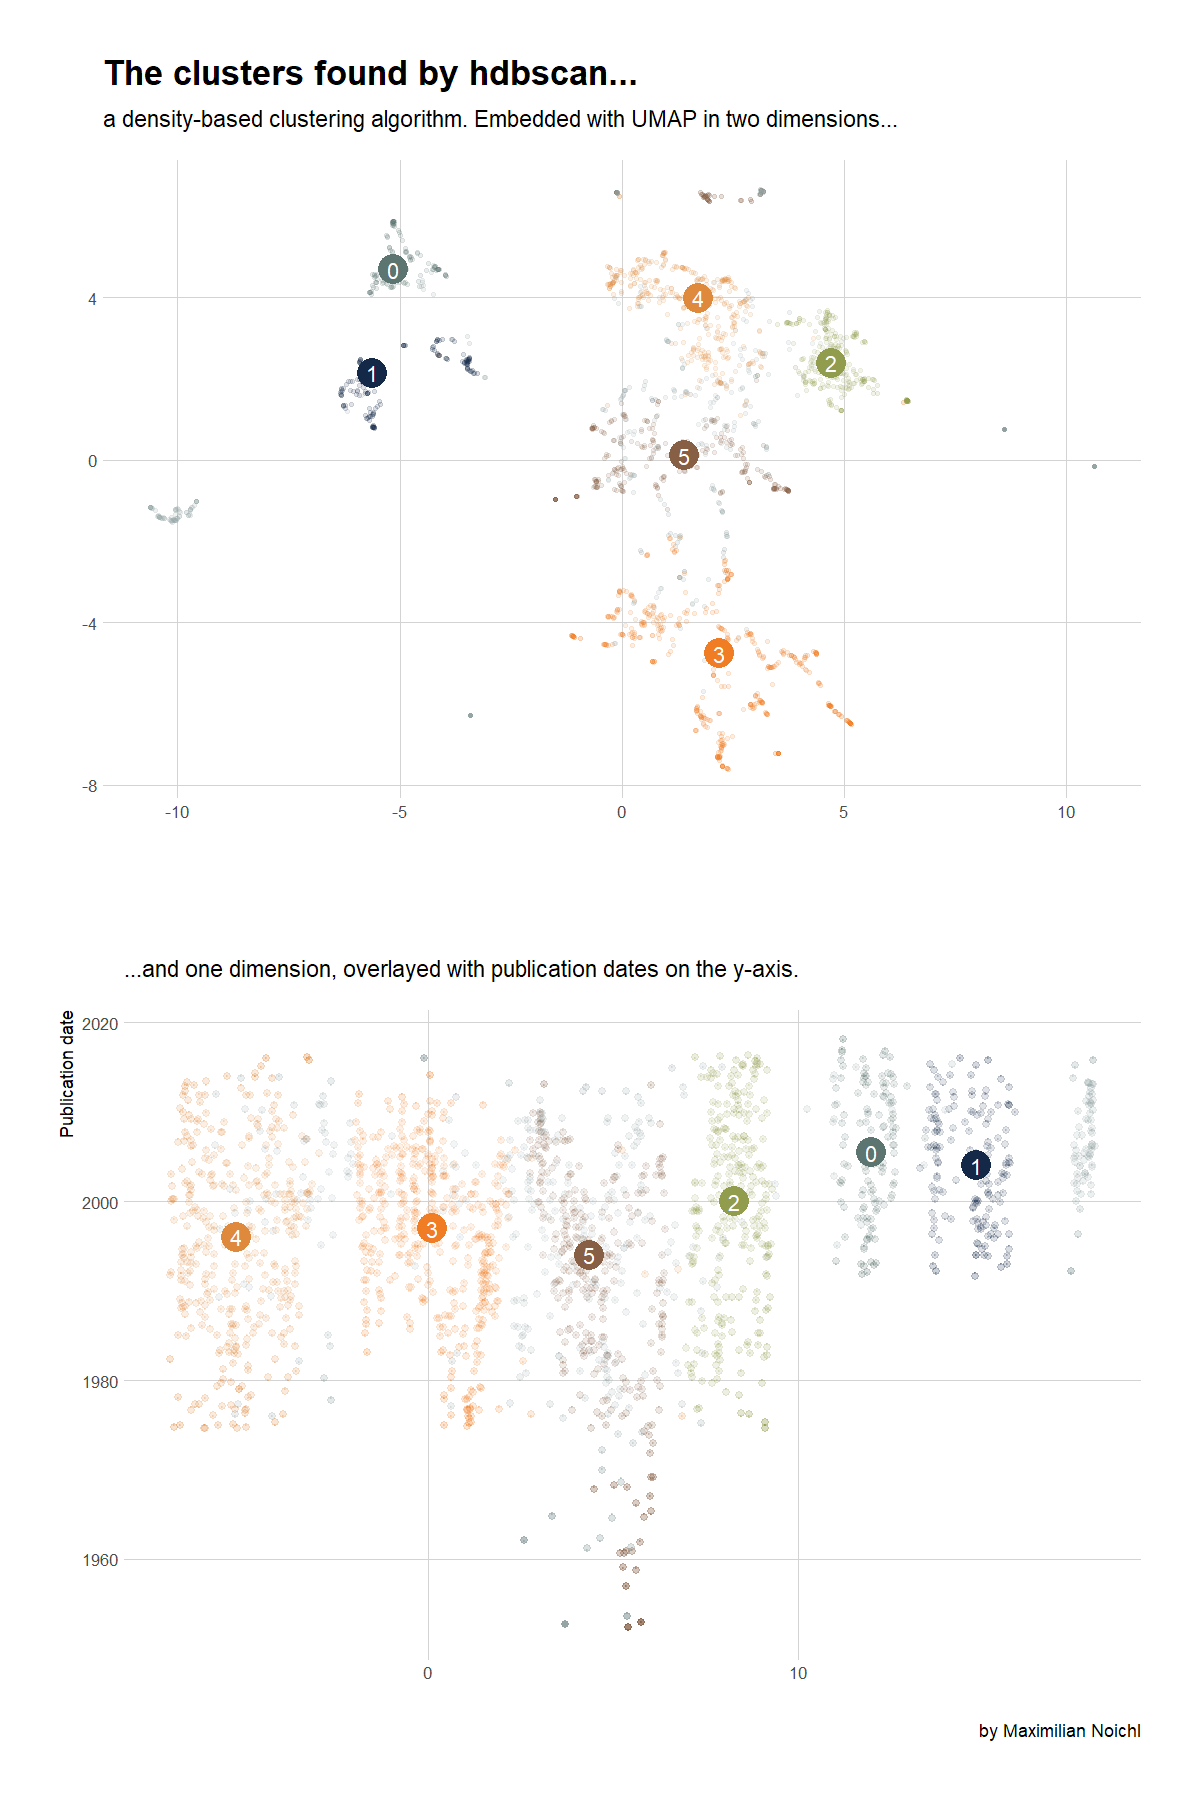

In [400]:
%%R -i embedding,dfclust,embeddingI -o myNewColors --width 1200 --height 1800 -r 140 #--bg #F8F4E9

library(hrbrthemes)
library(ggplot2)
library(fields)

options(warn=0)# 0 zum anschalten

#Get the cluster means:
means <- aggregate(embedding[,c("x","y")], list(dfclust$cluster), median)
means <- data.frame(means) 
n=nrow(means)
means <- means[-1,]

#Make the colors: 
mycolors <- c("#c03728","#919c4c","#fd8f24","#f5c04a","#e68c7c","#00666b","#142948","#6f5438") 

pal <- colorRampPalette(sample(mycolors))
s <- n-1
myGray <- c('#95a5a6')
myNewColors <- sample(pal(s))
myPal <- append(myGray,myNewColors)

#get temporal means:
tmeans <- aggregate(embeddingI[,c("xI","year")], list(dfclust$cluster), median)
tmeans <- data.frame(tmeans) 
tmeans <- tmeans[-1,]

#get density, to avoid overplotting
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

#get temporal density
embeddingI$density <- fields::interp.surface(
  MASS::kde2d(embeddingI$xI, embeddingI$year), embeddingI[,c("xI","year")])


p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y, color= as.factor(dfclust$cluster), alpha = 1/density))+
geom_point(pch=20,cex=1.6)+ 
theme_ipsum_rc()+
scale_color_manual(values = myPal) +
 guides(alpha=FALSE, color=FALSE)+
geom_point(data=means, aes(x=means$x, y=means$y), color= myNewColors, alpha = 1,size =7)+
annotate("text", x = means[,c("x")], y = means[,c("y")], label = means[,c("Group.1")], color="white", fontface="bold",  size=4, parse = TRUE, hjust=0.5)+
labs(x="", y="",
       title="The clusters found by hdbscan...",
       subtitle="a density-based clustering algorithm. Embedded with UMAP in two dimensions...")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank())


t <- ggplot(embeddingI, aes(x=embeddingI$xI, y=embeddingI$year, color= as.factor(dfclust$cluster), alpha = 1/density))+
geom_point(pch=20,cex=0.4)+
geom_jitter()+
theme_ipsum_rc()+
scale_color_manual(values = myPal) +
guides(alpha=FALSE, color=FALSE)+
geom_point(data=tmeans, aes(x=tmeans$x, y=tmeans$y), color= myNewColors, alpha = 1,size =7)+
annotate("text", x = tmeans[,c("xI")], y = tmeans[,c("year")], label = tmeans[,c("Group.1")], color="white", fontface="bold",  size=4, parse = TRUE, hjust=0.5)+
labs(x="", y="Publication date",
         subtitle="...and one dimension, overlayed with publication dates on the y-axis.",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank())


library(gridExtra)
grid.arrange(p,t, ncol = 1,  heights = c(1, 1))

# pdf("ClusteringUMap.pdf", width = 12, height = 12) # Open a new pdf file
# grid.arrange(p,t, ncol = 1,  heights = c(1, 1)) # Write the grid.arrange in the file\n",
# dev.off()



Thats nice. To have look into the way the clustering algorithm has structured the data, lets look at the condensed tree. 
I messed around a bit in my installation of HDBSCAN, so if you run this on your computer, your tree will propably look quite different.


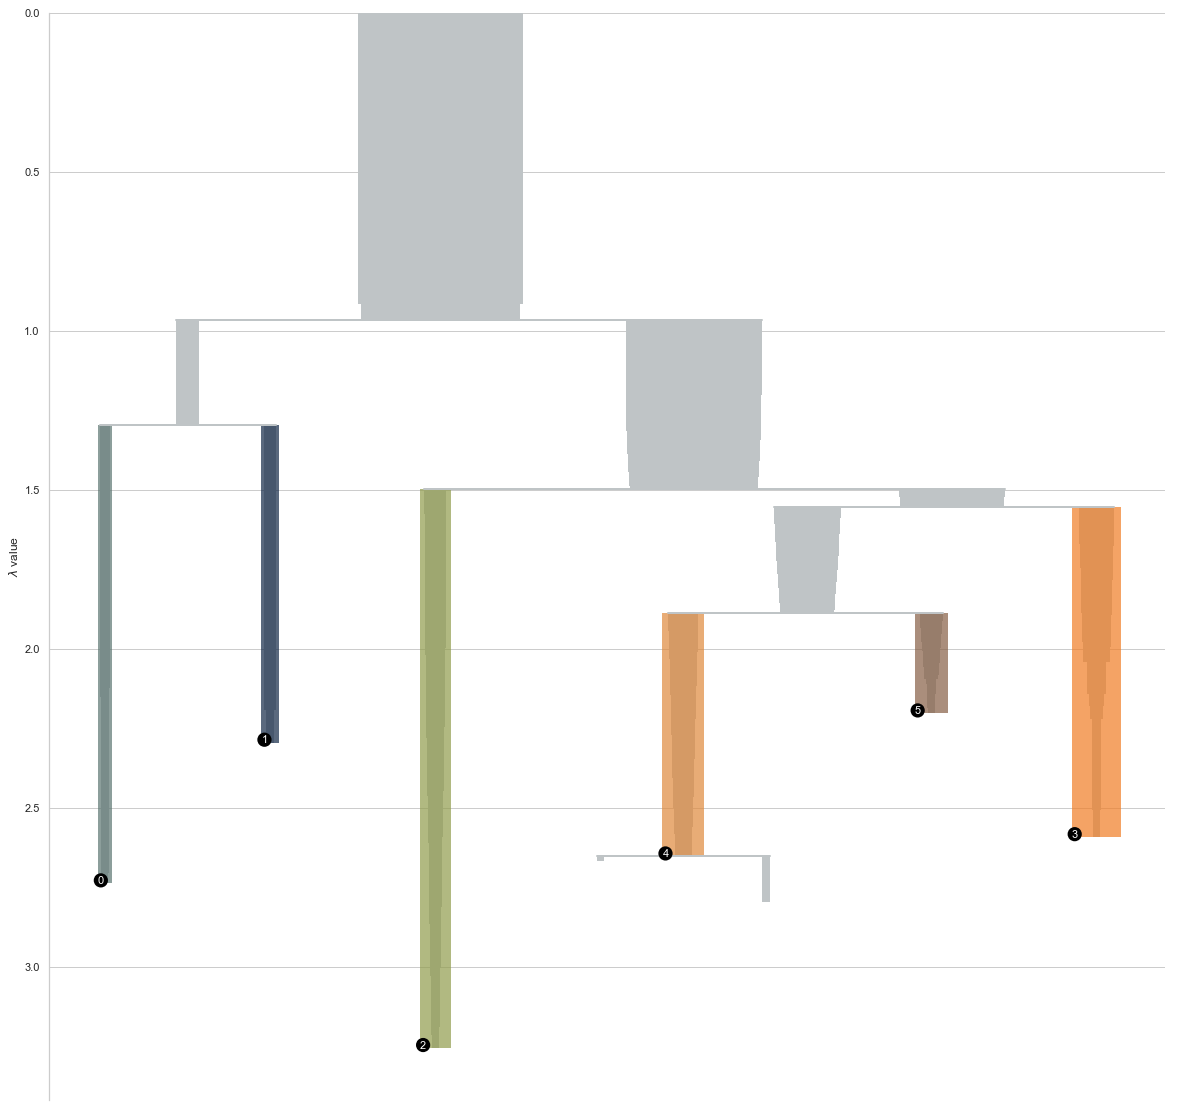

In [401]:
import matplotlib.colors
plt.rcParams['figure.figsize'] = [20, 20]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#bfc4c6","#bfc4c6","#bfc4c6"])

clusterer.condensed_tree_.plot(cmap = cmap,select_clusters=True,label_clusters = True, selection_palette=myNewColors, 
                               colorbar = False,max_rectangles_per_icicle=80, alpha=0.7,barwidthfactor=1,linecolor='#bfc4c6',linewidth=2)


### Evaluation
Now we look how well our clustering has captured the Journals we started with. They were all pretty different, so we should expect little overlap. A tiny bit is alright though, as we sacrificed some precision in order to be able to use more data by including the names of authors in our features.

In [402]:

drc = pd.concat([drc, dfclust],axis=1)
drc = drc.dropna(subset=['cluster'])
drc = pd.concat([drc, embedding],axis=1)


mean recall:  99.6 %


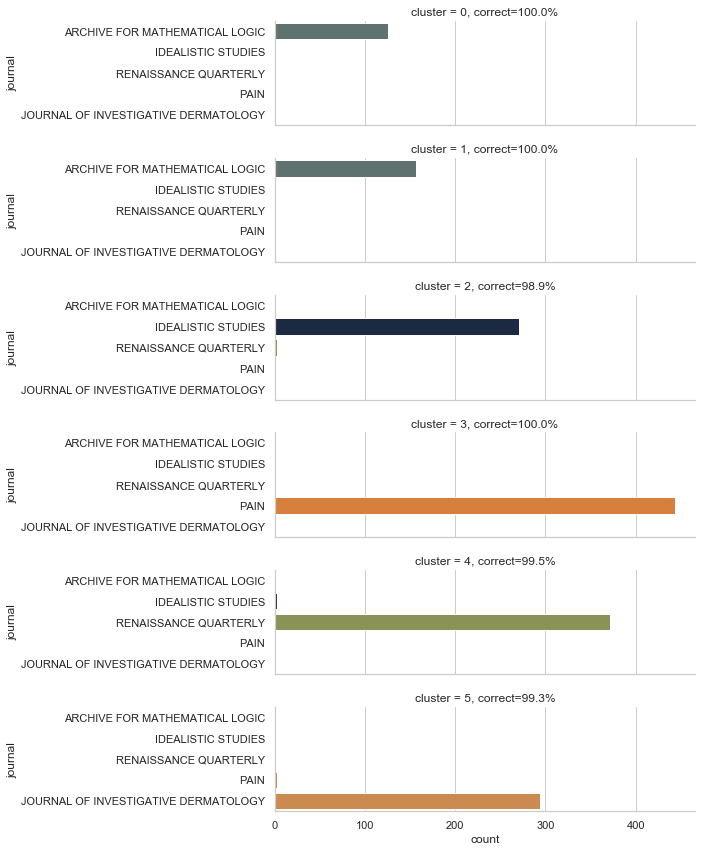

In [405]:
import statistics as s

fullstrsl = []
for x in range(0,clusternum):
    abstracts = list(drc.loc[drc['cluster'] == x]['journal'])
    fullstrsl.append(abstracts)
    
Jdata = pd.DataFrame(fullstrsl).transpose()
sns.set(style="whitegrid")
#f, ax = plt.subplots(figsize=(10, 6))
k = []
fit = []
for c in range(0,len(Jdata.columns)):
    top = Jdata[c].value_counts().tolist()
    source_data = Jdata[c].value_counts().to_frame()
    source_data.columns = ['count']
    source_data['journal'] = source_data.index
    source_data['cluster']=str(c) + ", correct=" + str(round(top[0]/sum(top)*100,1)) + "%"
    k.append(source_data.reset_index())
    fit.append(top[0]/sum(top)*100)
    
k = pd.concat(k)
print("mean recall: ", round(s.mean(fit),1),'%')
g = sns.catplot(x="count", y="journal", row="cluster",
                data=k, orient="h", height=2, aspect=5, palette=myNewColors, kind="bar", dodge=True)

As we can see, the papers were matched to their respective journals 99.6% of the time, which look pretty good to me. (We could normally gain a little bit more by using only cited works, without author names, but we loose a quite a bit of usable data, so I  think it's not worth it.) This means, that we can take the embeddings of UMAP, cluster them with HDBSCAN and be reasonably confident that the results contain meaningful information about the real structure of the scientific landscape.